### Calculation of the FID score for samples of images taken from strekeisen.it

Objective: evaluated effects of noise and median filtering applied to the same sample of images when comparing with the FID score to the original population, based on Heusel et al, 2017.



In [285]:

# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
import os 
import numpy as np
import os
import cv2, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### Functions to scale and calculate the fid, modified from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [2]:
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid


In [161]:
for i in os.listdir("imgs"):
    image = Image.open('imgs/'+i)
    image = image.convert('RGB')
    median = cv2.medianBlur(np.array(image), 21)
    median = Image.fromarray(median)
    median.save('imgs_median_21/'+i)

In [ ]:
for i in os.listdir("imgs"):
    image = Image.open('imgs/'+i)
    image = image.convert('RGB')
    median = cv2.medianBlur(np.array(image), 21)
    median = Image.fromarray(median)
    median.save('imgs_median_21/'+i)

#### Function to generate salt and pepper noise for a folder of images

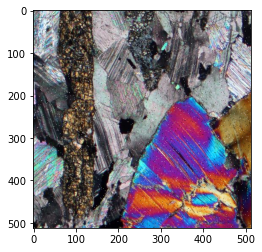

In [178]:

image = Image.open('sovite.png')

def sp_noise(image,prob):
    '''
    Add salt pepper noise
         PROB: Noise ratio 
    '''
    image = np.array(image)
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output
sp = sp_noise(image, 0.01)




#### Function to generate gaussian noise

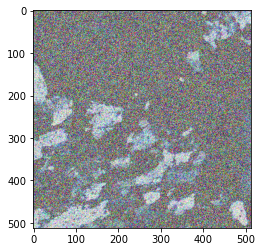

In [209]:
def gauss_noise(image, mean=0, var=0.1):
    ''' 
                 Add Gaussian noise
                 Mean: mean 
                 Var: variance
    '''
    image = np.array(image)
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    #cv.imshow("gasuss", out)
    return out

gauss = gauss_noise(image,0, 0.001)
plt.imshow(gauss)

In [281]:
for i in os.listdir("imgs"):
    image = Image.open('imgs/'+i)
    image = image.convert('RGB')
    sp = sp_noise(np.array(image), 0.1)
    sp = Image.fromarray(sp)
    sp.save('imgs_sp_nr_0_1/'+i)

In [273]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(512,512,3))

#### Testing the FID score for a salt and pepper "noised" image folder

In [282]:
imgs = []

for num in os.listdir(f"imgs"):
    image = Image.open('imgs/'+num)
    image = image.convert('RGB')
    # convert image to numpy array
    data = asarray(image)
    imgs.append(data)

np_imgs = np.array(imgs)

imgs2 = []
for i in os.listdir("imgs_sp_nr_0_1"):
    image = Image.open('imgs_sp_nr_0_1/'+i)
    image = image.convert('RGB')
    # convert image to numpy array
    data = asarray(image)
    imgs2.append(data)

np_imgs2 = np.array(imgs2)

images1 = np_imgs.astype('float32')
images2 = np_imgs2.astype('float32')
# resize images
images1 = scale_images(images1, (512,512,3))
images2 = scale_images(images2, (512,512,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print(f'FID for sp noise with noise ration = 0.01 kernel: %.3f' % fid)

Scaled (24, 512, 512, 3) (24, 512, 512, 3)
FID for sp noise with noise ration = 0.01 kernel: 80.358


In [162]:
imgs = []

for num in os.listdir(f"imgs"):
    image = Image.open('imgs/'+num)
    image = image.convert('RGB')
    # convert image to numpy array
    data = asarray(image)
    imgs.append(data)

np_imgs = np.array(imgs)




#### Testing the FID score for a median filtered image folder

In [164]:
fid_scores = []

for i in [3,9,15,21]:

    num = str(i)
    
    imgs2 = []

    print(f"IMG FOlDER: imgs_median_{num}")
    for item in os.listdir(f"imgs_median_{num}"):
        image = Image.open(f'imgs_median_{num}/'+item)
        image = image.convert('RGB')
        # convert image to numpy array
        data = asarray(image)
        imgs2.append(data)

    else:
        np_imgs2 = np.array(imgs2)
        images1 = np_imgs.astype('float32')
        images2 = np_imgs2.astype('float32')
        # resize images
        images1 = scale_images(images1, (512,512,3))
        images2 = scale_images(images2, (512,512,3))
        print('Scaled', images1.shape, images2.shape)
        # pre-process images
        images1 = preprocess_input(images1)
        images2 = preprocess_input(images2)
        # calculate fid
        fid = calculate_fid(model, images1, images2)
        print(f'FID for median filter with {num}x{num} kernel: %.3f' % fid)

IMG FOlDER: imgs_median_3
Scaled (24, 512, 512, 3) (24, 512, 512, 3)
FID for median filter with 3x3 kernel: 21.794
IMG FOlDER: imgs_median_9
Scaled (24, 512, 512, 3) (24, 512, 512, 3)
FID for median filter with 9x9 kernel: 88.977
IMG FOlDER: imgs_median_15
Scaled (24, 512, 512, 3) (24, 512, 512, 3)
FID for median filter with 15x15 kernel: 106.236
IMG FOlDER: imgs_median_21
Scaled (24, 512, 512, 3) (24, 512, 512, 3)
FID for median filter with 21x21 kernel: 116.162


#### Graphs for generated FID values

Text(23.875, 0.5, 'FID Score')

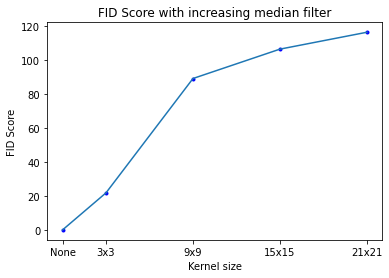

In [279]:
plt.plot([0,3,9,15,21], [0,21.794,88.977,106.236,116.162], ".", c="blue")
plt.plot([0,3,9,15,21], [0,21.794,88.977,106.236,116.162])
plt.xlabel('Kernel size')
ticks = [0,3,9,15,21]
labels = ["None","3x3", "9x9","15x15","21x21"]
plt.xticks(ticks, labels)
plt.title("FID Score with increasing median filter")
#plt.gca().invert_xaxis()
plt.savefig("fidmedian.jpg", dpi=300)
plt.ylabel("FID Score")

Text(23.875, 0.5, 'FID Score')

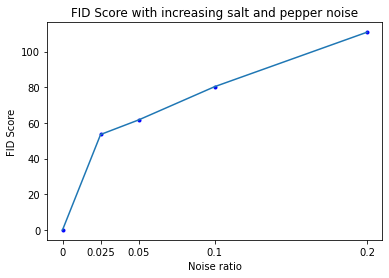

In [283]:
plt.plot([0,0.025,0.05,0.1,0.2], [0,53.518,61.685,80.358,110.865], ".", c="blue")
plt.plot([0,0.025,0.05,0.1,0.2], [0,53.518,61.685,80.358,110.865])
plt.xlabel('Noise ratio')
#plt.yscale("log")
ticks = [0,0.025,0.05,0.1,0.2]
labels = ["0","0.025", "0.05","0.1","0.2"]
plt.xticks(ticks, labels)
plt.title("FID Score with increasing salt and pepper noise")
#plt.gca().invert_xaxis()
plt.savefig("fidnoise.jpg", dpi=300)
plt.ylabel("FID Score")

In [111]:
ls2 = []
for i in os.listdir("imgs_test"):
    image = Image.open('imgs_test/'+i)
    image = image.convert('RGB')
    # convert image to numpy array
    data = asarray(image)
    ls2.append(data)

In [133]:


ls3 = []
for i in os.listdir("imgs_median_11"):
    image = Image.open('imgs_median_11/'+i)
    image = image.convert('RGB')
    # convert image to numpy array
    data = asarray(image)
    ls3.append(data)